In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import open3d as o3d

# Data structures and functions for rendering
from pytorch3d import ops
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVOrthographicCameras,
    PointLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    TexturesVertex
)

from pyqtgraph.opengl import MeshData, GLMeshItem
from pyqtgraph import AxisItem, GradientEditorItem

from python.optimisation_funcs import manufacturingSurrogateModels_bulkhead, manufacturingSurrogateModels_ubending, autodecoder

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
file = "/Users/alexlee/OneDrive - Imperial College London/Year 4/Masters/code/masters_3d/temp/optimisation/OptimisationOutputs/u-bending/case2_LatentVectorsForPlotting.pkl"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
latentVectorsForPlotting = torch.load(file, map_location=device)
num_designs = len(latentVectorsForPlotting)
showing_num_design = int(round(num_designs, 0))
latentForOptimization = latentVectorsForPlotting[showing_num_design-1][-1]
verts, faces = autodecoder.get_verts_faces(latentForOptimization, None, "u-bending")

decoder for u-bending


In [3]:
def displacementsToPositions(totalDisplacementField):
  
    # Store the output from the displacement model
    totalDisplacementField = totalDisplacementField.squeeze().clone()

    # Get the displacement vectors as images
    displacement_x = totalDisplacementField[0]
    displacement_y = totalDisplacementField[1]
    displacement_z = totalDisplacementField[2]

    # Create a meshgrid of x and y coordinates for each pixel in the images
    x_coords = torch.linspace(0, 160, displacement_x.shape[1])
    y_coords = torch.linspace(0, 80, displacement_x.shape[0])
    x_mesh, y_mesh = torch.meshgrid(x_coords, y_coords)

    # Calculate the 3D coordinates of each point
    x_coords_deformedComponent = x_mesh.to(device).T + displacement_x
    y_coords_deformedComponent = y_mesh.to(device).T + displacement_y
    z_coords_deformedComponent = displacement_z

    # Stack the three tensors along a new dimension. Shape: torch.Size([1, 3, 256, 512])
    deformed_component_positions = torch.stack((x_coords_deformedComponent, 
                                                y_coords_deformedComponent, 
                                                z_coords_deformedComponent), dim=0).unsqueeze(0)

    return deformed_component_positions

In [4]:
def geometryPositionsImageTo3DPoints(geometryPositionsImage, thinningField, vmin, vmax):

    # Store the input
    geometryPositionsImageForPlotting = geometryPositionsImage.squeeze().cpu().clone()

    if thinningField is not None:
        thinningField = thinningField.squeeze().detach().cpu().clone()

    norm = plt.Normalize(vmin=vmin, vmax=vmax)

    # Get the 3D coordinates of each point
    x_coords_deformedComponent = geometryPositionsImageForPlotting[0]
    y_coords_deformedComponent = geometryPositionsImageForPlotting[1]
    z_coords_deformedComponent = geometryPositionsImageForPlotting[2]

    fig, ax = plt.subplots(subplot_kw={"projection": "3d"},figsize=(8, 6), dpi=100)

    if thinningField is not None:
        ax.plot_surface(x_coords_deformedComponent.detach().cpu().numpy(), 
                        y_coords_deformedComponent.detach().cpu().numpy(), 
                        z_coords_deformedComponent.detach().cpu().numpy(), 
                        facecolors=plt.cm.jet(norm(thinningField.numpy())),
                        rstride=1,cstride=1, linewidth=0, antialiased=False, shade=False, alpha=1)
    else:
        ax.plot_surface(x_coords_deformedComponent.detach().cpu().numpy(), 
                        y_coords_deformedComponent.detach().cpu().numpy(), 
                        z_coords_deformedComponent.detach().cpu().numpy(), 
                        color='darkgray',
                        rstride=1,cstride=1, linewidth=0, antialiased=False, shade=True, alpha=1)

    ax.view_init(10, -80)
    ax.set_xlim3d(0, 120)
    ax.set_ylim3d(0, 80)
    ax.set_zlim3d(-80, 0)

    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.grid(False)
    ax.axis('off')

    plt.show()

/var/folders/vq/8tw_x9796214x5ztxkg8rkt80000gn/T/ipykernel_53580/3793863931.py:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  BHF = torch.tensor(surrogateModelInput[2].mean(), requires_grad=True)
/var/folders/vq/8tw_x9796214x5ztxkg8rkt80000gn/T/ipykernel_53580/3793863931.py:106: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  friction = torch.tensor(surrogateModelInput[3].mean(), requires_grad=True)
/var/folders/vq/8tw_x9796214x5ztxkg8rkt80000gn/T/ipykernel_53580/3793863931.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  clearance

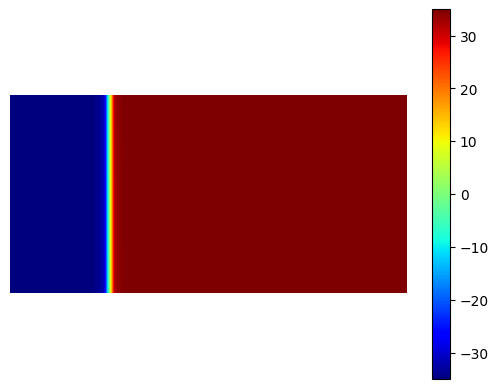

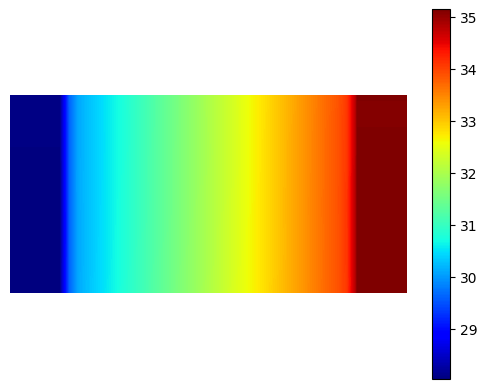

Depth map of reconstructed shape


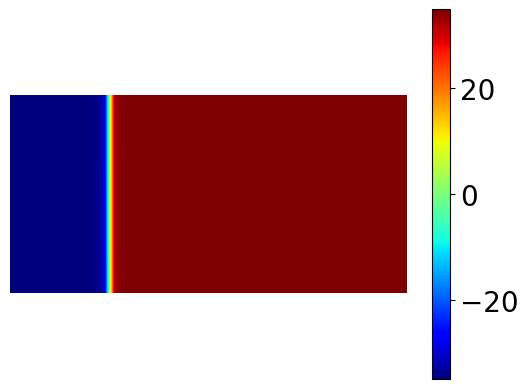

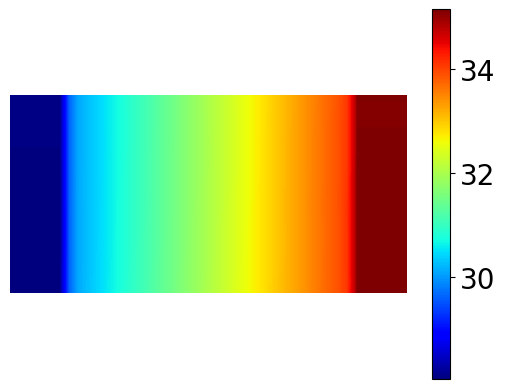

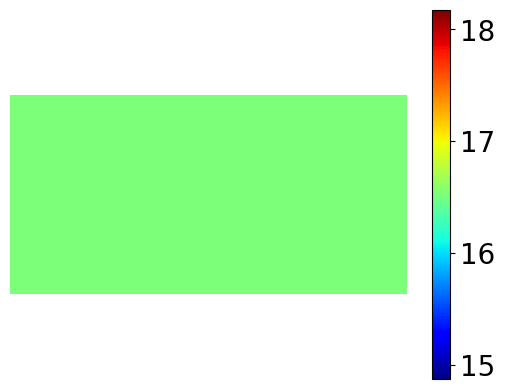

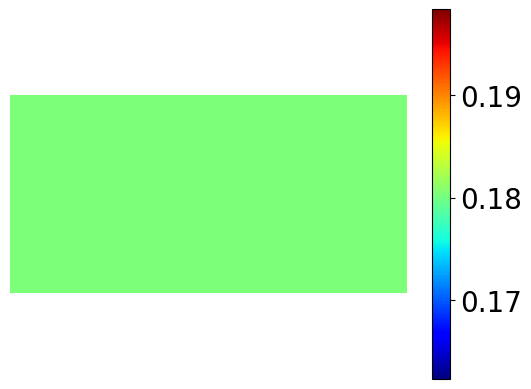

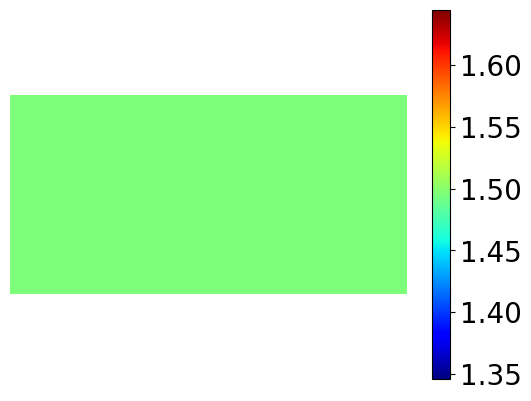

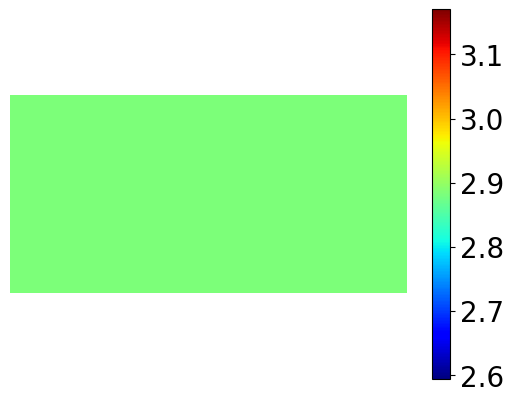

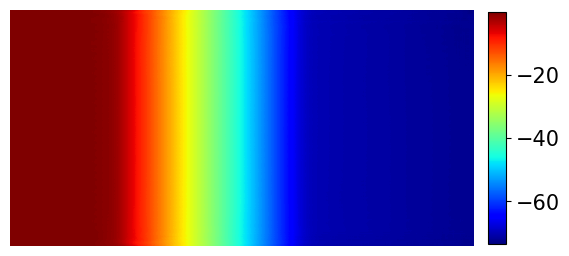

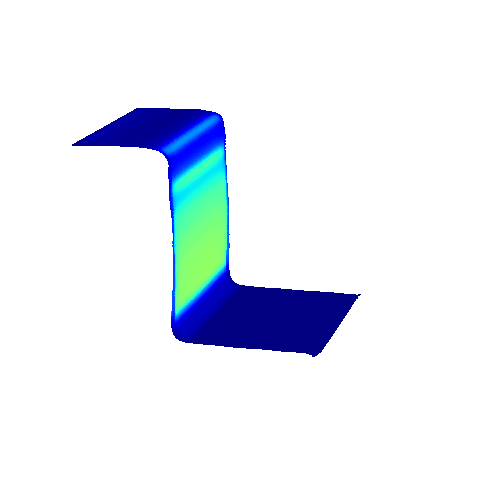

In [6]:
#hyperparameters surrogate model
batch_size = 4
num_channel_thinning = (np.array([4,8,16,32,64,128,256,512])).astype(np.int64)
num_channel_displacement = (np.array([4,8,16,32,64,128,256,512])).astype(np.int64)

#load trained NN3 manufacturing constraints surrogate models
#load trained model
thinningModel = manufacturingSurrogateModels_ubending.ResUNet_Thinning(num_channel_thinning,batch_size)
thinningModel = thinningModel.to(device)
thinningModel.load_state_dict(torch.load("python/optimisation_funcs/model_confirugrations/u-bending/ResSEUNet_512_B4_2000_COS0.0_LRFix0.0002_E4B6D4_NewShape_08Feb23_best.pkl",map_location=device))
thinningModel.eval()

displacementModel = manufacturingSurrogateModels_ubending.ResUNet_totalDisplacement(num_channel_displacement,batch_size)
displacementModel = displacementModel.to(device)
displacementModel.load_state_dict(torch.load("python/optimisation_funcs/model_confirugrations/u-bending/ResSEUNet_512_B4_2000_COS0.0_VECD0.5_LRFix0.0001_E6B6D6_disp_MAE_27Feb23_best.pkl",map_location=device))
displacementModel.eval()

#------------------------------------------------------------------------------------------------------------------------------
#Rasteriser 1: Rasteriser settings for top view orthographic projection 
#------------------------------------------------------------------------------------------------------------------------------
refLengthDies = 168 
additionalDistance = 75
CAMERA_DISTANCE_ZProjection = additionalDistance
AZIMUTH = 0
ELEVATION = 0
IMAGE_SIZE = 256
R, T = look_at_view_transform(dist = CAMERA_DISTANCE_ZProjection, elev = ELEVATION, azim = AZIMUTH) 
# cameras = FoVOrthographicCameras(max_y = 0.47, min_y = 0, max_x = -0.17, min_x = -0.83, device=device, R=R, T=T) #<============= DEVICE SET AS CPU FOR NOW SINCE MeshRasteriser not working properly on GPu

#how to calculate coordinates:
#y direction is simple
#x direction: the magnitude of (min_x - max_x should equal half the x side length, which is 168mm for the U-channel)
cameras = FoVOrthographicCameras(max_y = 83, min_y = 0, max_x = -42, min_x = -126, device=device, R=R, T=T) #<============= DEVICE SET AS CPU FOR NOW SINCE MeshRasteriser not working properly on GPu


# Here we set the output image to be of size 256 x 256
raster_settings = RasterizationSettings(image_size = (IMAGE_SIZE, int(IMAGE_SIZE*2)), blur_radius = 1e-16, faces_per_pixel = 1) #set a small blur radius to avoid -1 regions in the image (not captured by camera rays). See PyTorch3D documentation
# raster_settings = RasterizationSettings(image_size = (IMAGE_SIZE, IMAGE_SIZE), blur_radius = 1e-16, faces_per_pixel = 1) #set a small blur radius to avoid -1 regions in the image (not captured by camera rays). See PyTorch3D documentation

# Initialize rasterizer by using a MeshRasterizer class and store depth map
rasterizer_ZProjection = MeshRasterizer(cameras=cameras, raster_settings=raster_settings)
        
#------------------------------------------------------------------------------------------------------------------------------
#Rasteriser 2: Rasteriser settings for X axis orthographic projection 
#------------------------------------------------------------------------------------------------------------------------------
refLengthDies = 168
additionalDistance = 10

CAMERA_DISTANCE_XProjection = refLengthDies# + additionalDistance
AZIMUTH = 90
ELEVATION = 0
IMAGE_H = 256
IMAGE_W = 384

R, T = look_at_view_transform(dist = CAMERA_DISTANCE_XProjection, elev = ELEVATION, azim = AZIMUTH) 
# cameras = FoVOrthographicCameras(max_y = 0.47, min_y = 0, max_x = -0.17, min_x = -0.83, device=device, R=R, T=T) #<============= DEVICE SET AS CPU FOR NOW SINCE MeshRasteriser not working properly on GPu

#how to calculate coordinates:
#here, the min_x and max_x refer to the Z-axis in world space
#()
cameras = FoVOrthographicCameras(max_y = 83, min_y = 0, max_x = 22.2665, min_x = -22.2665, device=device, R=R, T=T) #<============= DEVICE SET AS CPU FOR NOW SINCE MeshRasteriser not working properly on GPu

# Here we set the output image to be of size 256 x 256
raster_settings = RasterizationSettings(image_size = (IMAGE_SIZE, IMAGE_W), blur_radius = 1e-16, faces_per_pixel = 1) #set a small blur radius to avoid -1 regions in the image (not captured by camera rays). See PyTorch3D documentation
# raster_settings = RasterizationSettings(image_size = (IMAGE_SIZE, IMAGE_SIZE), blur_radius = 1e-16, faces_per_pixel = 1) #set a small blur radius to avoid -1 regions in the image (not captured by camera rays). See PyTorch3D documentation

# Initialize rasterizer by using a MeshRasterizer class and store depth map
rasterizer_XProjection = MeshRasterizer(cameras=cameras, raster_settings=raster_settings)

rasterizers = [rasterizer_ZProjection, rasterizer_XProjection]

#-------------------------------------------------------------------------------------
#1.3: Transform the output of MC to match the training data. I.e., the configuration that the network was trained on
#-------------------------------------------------------------------------------------

#rotate
# verts = rotateAboutZAxis(90, verts)

#translate
verts[:,0] = verts[:,0] - verts[:,0].min()
verts[:,1] = verts[:,1] - verts[:,1].min()
verts[:,2] = verts[:,2] - verts[:,2].max()
verts[:,2] = verts[:,2] - verts[:,2].min()/2 #ensure mid height of 0. This is needed for the x-projections

#undo scaling due to marching cubes
# NOTE: its important to have the correct dimentions here, since this will ensure the image projections are also correct
verts = verts/(verts[:,0].max() - verts[:,0].min()) #ensure side length of 1
verts = verts * refLengthDies

#-------------------------------------------------------------------------------------
#1.4: Prepare for rasteriser
#-------------------------------------------------------------------------------------
xyz_upstream = torch.tensor(verts.astype(float), requires_grad = True, dtype = torch.float32, device = device) 
faces_upstream = torch.tensor(faces.astype(float), requires_grad = False, dtype=torch.float32, device =device) 
mesh = Meshes(verts=[xyz_upstream], faces=[faces_upstream])

sampleNo = 157 #initial design

loadedInputForDisplacementModelImages_original = np.load("python/optimisation_funcs/model_confirugrations/u-bending/ModelPreparation/NN2_ManufacturingSurrogate/UBending_models_newgeo/InputTestOriginalAndNN_Feb23.npy") #for blank shape 
loadedInputForDisplacementModelImages = loadedInputForDisplacementModelImages_original[sampleNo].copy()
surrogateModelInput = torch.tensor(loadedInputForDisplacementModelImages).float().to(device)

gridOfOnes = torch.ones_like(surrogateModelInput[2])

BHF = torch.tensor(surrogateModelInput[2].mean(), requires_grad=True)
friction = torch.tensor(surrogateModelInput[3].mean(), requires_grad=True)
clearance = torch.tensor(surrogateModelInput[4].mean(), requires_grad=True)
thickness = torch.tensor(surrogateModelInput[5].mean(), requires_grad=True)

surrogateModelInput = surrogateModelInput.unsqueeze(0)

#-------------------------------------------------------------------------------------
#1.5: Project to image
#-------------------------------------------------------------------------------------
for count, rasterizer_projection in enumerate(rasterizers):
    fragments = rasterizer_projection(mesh)
    depthMap = fragments.zbuf.squeeze() #no need for a renderer just use the rasterizer to obtain the depth map
    depthMap = depthMap.to(device)

    if count == 1:
        depthMap = -1 * (depthMap - CAMERA_DISTANCE_XProjection + 10) #added 10 here because this would match the X-projections to the ones given for the training data. In the X-projections generating script, the projection was done using an old set of codes which were overwriten
        edge1 = torch.repeat_interleave(depthMap[:, -1].unsqueeze(1), repeats = 64, dim = 1)
        edge2 = torch.repeat_interleave(depthMap[:, 0].unsqueeze(1), repeats = 64, dim = 1)
        depthMap = torch.cat((edge2, depthMap, edge1), dim = 1)
    else:
        depthMap = (depthMap - CAMERA_DISTANCE_ZProjection)

    # for plotting only
    depthMapForPlotting = depthMap.detach().cpu().numpy() 
    # plt.figure(figsize=(100,50))
    plt.imshow(depthMapForPlotting, cmap='jet')
    plt.colorbar()
    plt.axis("off")
    plt.show()

    surrogateModelInput[:, count, :, :] = depthMap

surrogateModelInput[:, 2, :, :] = BHF * gridOfOnes #BHF
surrogateModelInput[:, 3, :, :] = friction * gridOfOnes #friction
surrogateModelInput[:, 4, :, :] = clearance * gridOfOnes #clearance
surrogateModelInput[:, 5, :, :] = thickness * gridOfOnes #thickness

#plot reconstucted image
print("Depth map of reconstructed shape")
for i in range(surrogateModelInput.squeeze().shape[0]):
    depthMapForPlotting = surrogateModelInput.squeeze()[i].detach().cpu().numpy()
    plt.imshow(depthMapForPlotting, cmap='jet')
    cbar = plt.colorbar(orientation="vertical")
    cbar.ax.tick_params(labelsize=20)
    plt.axis("off")
    plt.show()

#-------------------------------------------------------------------------------------
#2.1: Using NN3, calculate manufacturing performance
#-------------------------------------------------------------------------------------
thinningField = thinningModel(surrogateModelInput)[..., :-10]
totalDisplacementField = displacementModel(surrogateModelInput).squeeze() #total displacement
postStampingAndSpringbackGeometryPositions = displacementsToPositions(totalDisplacementField)[..., :-10] #deformed positions

# plt.figure(figsize=(10,5))
plt.imshow(postStampingAndSpringbackGeometryPositions.squeeze()[2].detach().cpu().numpy(), cmap='jet')
plt.axis('off')
cbar = plt.colorbar(fraction=0.036, pad=0.03, aspect=13)
cbar.ax.tick_params(labelsize=15)
plt.show()

geometryPositionsImageTo3DPoints(postStampingAndSpringbackGeometryPositions, thinningField, vmax = 0.2, vmin=0)

# postStampingAndSpringbackGeometryPositions = torch.reshape(postStampingAndSpringbackGeometryPositions, (128512,3)).detach().numpy()
# postStampingAndSpringbackGeometryPositions = torch.squeeze(postStampingAndSpringbackGeometryPositions)
# print(postStampingAndSpringbackGeometryPositions.shape)
# postStampingAndSpringbackGeometryPositions = postStampingAndSpringbackGeometryPositions.flatten(1,2)
# print(postStampingAndSpringbackGeometryPositions.shape)
# postStampingAndSpringbackGeometryPositions = torch.transpose(postStampingAndSpringbackGeometryPositions, 0, 1).detach().numpy()
# print(postStampingAndSpringbackGeometryPositions.shape)


# Use Open3D to plot smooth surface
# pcd = o3d.geometry.PointCloud()
# pcd.points = o3d.utility.Vector3dVector(postStampingAndSpringbackGeometryPositions)
# o3d.visualization.draw_geometries([pcd])
# Create and estimate normals
# pcd.normals =  o3d.utility.Vector3dVector(np.zeros((1,3)))
# pcd.estimate_normals()
# alpha = 0.03
# o3dmesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(pcd, alpha)
# o3dmesh.compute_vertex_normals()
# o3dmesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=9)
# radii = [0.005, 0.01, 0.02, 0.04]
# o3dmesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(pcd, o3d.utility.DoubleVector(radii))